# SiamMAE

In [1]:
import torch
from mae.models_mae import  mae_vit_base_patch16

In [2]:
from dataset_loader.dataset import get_kinetics_dataset, unnormalize_for_plot, unnormalize

/home/eele/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


In [3]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    
print("Using device =", device)

Using device = cuda


In [4]:
data = get_kinetics_dataset("./dataset/")

Loading dataset from ./dataset/
min_gap: 4, max_gap: 48, temporal_dim: -3, repeated_sampling: 1


In [5]:
print(data.num_videos)

711


In [5]:
BATCH_SIZE = 8

data_loader = torch.utils.data.DataLoader(
    data,
    batch_size=BATCH_SIZE,
)

torch.Size([8, 2, 3, 224, 224])


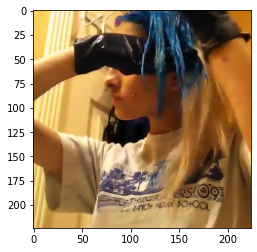

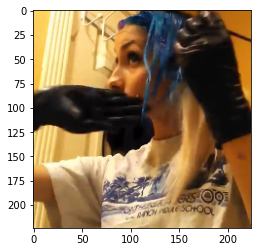

In [6]:
# torch.Size([3, 3, 224, 224])
from dataset_loader.dataset import unnormalize
import matplotlib.pyplot as plt


for batch in data_loader:
    print(batch["video"].shape)
    # torch.Size([8, 4, 3, 224, 224])
    # [BATCH_SIZE x Frames x Channel x Height x Width ]

    for i in range(batch["video"].shape[1]):
        plt.imshow(unnormalize_for_plot(batch["video"][0][i]))
        plt.show()
    break

In [6]:
mae_model = mae_vit_base_patch16().to(device)
mae_model2 = mae_vit_base_patch16().to(device)

In [9]:
# "We use the ViT-S/16 model for most of our experiments as it is similar to ResNet-50 in
# terms of the number of parameters (21M vs 23M) and allows for fair comparisons across different
# self-supervised learning and correspondence learning methods."

In [8]:
# A cross decoder consists of decoder blocks with only cross-attention layers, where tokens from f2
# attend to the tokens from f1.
class CrossDecoder(torch.nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.multihead_attn = torch.nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, f1, f2):
        # f1: ([BATCH_SIZE, 196, N])
        # f2: ([BATCH_SIZE, 50, N])

        # Reshape f1 and f2 to fit the input shape requirement of MultiheadAttention
        # which is (seq_len, batch_size, embed_dim)
        f1 = f1.transpose(0, 1)
        f2 = f2.transpose(0, 1)

        # MultiheadAttention takes in the query, key, value. Here we use f2 to attend to f1
        attn_output, _ = self.multihead_attn(f2, f1, f1)

        # Reshape the output back to the original shape
        attn_output = attn_output.transpose(0, 1)

        return attn_output

In [9]:
class SiamMAE(torch.nn.Module):
    def __init__(self, mae, mae2):
        super().__init__()
        self.mae = mae
        self.mae2 = mae2
        self.cross_decoder = CrossDecoder(embed_dim=768, num_heads=12).to(device)

    def forward(self, x):
        frame_one = x[:, 0, :, :, :]
        frame_next = x[:, 1, :, :, :]

        frame_one_x, _frame_one_mask, frame_one_ids = self.mae.forward_encoder(frame_one, mask_ratio = 0)
        frame_one_x = frame_one_x[:, 1:, :]

        frame_next_x, frame_next_mask, frame_next_ids = self.mae2.forward_encoder(frame_next, mask_ratio = 0.75)

        cross_decoded = self.cross_decoder(frame_one_x, frame_next_x)

        pred = self.mae2.forward_decoder(cross_decoded, frame_next_ids)
        loss = self.mae2.forward_loss(frame_next, pred, frame_next_mask)
        return loss, pred, frame_next_mask


In [12]:
from datetime import datetime
from tqdm import tqdm
import os 

def train_one_epoch(data_loader, optimizer,scheduler, criterion, device, model):
    losses = []
    for i, batch in tqdm(enumerate(data_loader)):
        batch = batch["video"].to(device)
        optimizer.zero_grad()
        output = model(batch)[0]
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        scheduler.step()
    return losses

EPOCHS = 60 
now = datetime.now().strftime('%Y-%m-%d_%H:%M:%S')

file_to_store_losses_path = f"./losses/{now}.txt" 

folder_to_store_checkpoints = f"./checkpoints/{now}"
os.makedirs(folder_to_store_checkpoints, exist_ok=True)

model = SiamMAE(mae_model, mae_model2).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=1.5e-4, weight_decay=0.05, betas=(0.9, 0.95))
sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim, T_0=10, eta_min=1e-6)
loss = torch.nn.MSELoss()

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}")

    model.train()
    losses = train_one_epoch(data_loader, optim, sched, loss, device, model)
    sched.step()
    avg_loss = sum(losses)/len(losses)
    print(f"Avg Loss: {avg_loss}")

    with open(file_to_store_losses_path, "a") as f:
        f.write(f"Epoch {epoch+1} - Avg Loss: {avg_loss} Losses - {losses} \n")

    # save checkpoint of model after each epoch in folder_to_store_checkpoints/{epoch_number}.pt
    if (epoch+1) % 10 == 0:
    # https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html
        torch.save(model, f"{folder_to_store_checkpoints}/{epoch+1}.pt")

Epoch 1


0it [00:00, ?it/s]

/home/eele/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8, 2, 3, 224, 224])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
88it [06:03,  5.02s/it]/home/eele/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([7, 2, 3, 224, 224])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
89it [06:06,  4.12s/it]


Avg Loss: 3.839482947681727
Epoch 2


89it [05:34,  3.75s/it]


Avg Loss: 3.2138407592023355
Epoch 3


89it [05:38,  3.80s/it]


Avg Loss: 3.1742505397689476
Epoch 4


89it [05:23,  3.64s/it]


Avg Loss: 3.2672121752513927
Epoch 5


89it [05:25,  3.65s/it]


Avg Loss: 3.115172162484587
Epoch 6


89it [05:24,  3.65s/it]


Avg Loss: 3.0964999707897056
Epoch 7


89it [05:26,  3.67s/it]


Avg Loss: 3.1470764486977223
Epoch 8


89it [05:22,  3.62s/it]


Avg Loss: 3.1110010562318093
Epoch 9


89it [05:21,  3.61s/it]


Avg Loss: 3.029114349504535
Epoch 10


89it [05:15,  3.55s/it]


Avg Loss: 2.95223124107618
Epoch 11


89it [05:34,  3.76s/it]


Avg Loss: 2.835506364200892
Epoch 12


89it [05:18,  3.58s/it]


Avg Loss: 3.1096683231632363
Epoch 13


89it [05:21,  3.61s/it]


Avg Loss: 2.8868413225988325
Epoch 14


89it [05:21,  3.61s/it]


Avg Loss: 2.8257873795005715
Epoch 15


89it [05:24,  3.64s/it]


Avg Loss: 2.720016969723648
Epoch 16


89it [05:18,  3.57s/it]


Avg Loss: 2.5691821628742004
Epoch 17


89it [05:19,  3.59s/it]


Avg Loss: 2.4663667009117898
Epoch 18


89it [05:18,  3.58s/it]


Avg Loss: 2.5494320352425737
Epoch 19


89it [05:16,  3.56s/it]


Avg Loss: 2.3038668257466863
Epoch 20


89it [05:19,  3.59s/it]


Avg Loss: 2.2488085848561834
Epoch 21


89it [05:46,  3.90s/it]


Avg Loss: 2.2421722197800538
Epoch 22


89it [05:23,  3.64s/it]


Avg Loss: 2.2316099646386136
Epoch 23


89it [05:19,  3.59s/it]


Avg Loss: 2.199414599477575
Epoch 24


89it [05:22,  3.63s/it]


Avg Loss: 2.1873511598351296
Epoch 25


89it [05:22,  3.63s/it]


Avg Loss: 2.167729987187332
Epoch 26


89it [05:21,  3.62s/it]


Avg Loss: 2.1433601473154646
Epoch 27


89it [05:18,  3.58s/it]


Avg Loss: 2.110021986318438
Epoch 28


89it [05:21,  3.62s/it]


Avg Loss: 2.062227066982998
Epoch 29


89it [05:22,  3.62s/it]


Avg Loss: 2.1375356175926292
Epoch 30


89it [05:18,  3.58s/it]


Avg Loss: 2.1086096830582353
Epoch 31


89it [05:26,  3.66s/it]


Avg Loss: 2.1243969436441916
Epoch 32


89it [05:21,  3.62s/it]


Avg Loss: 2.1162677266624534
Epoch 33


89it [05:26,  3.66s/it]


Avg Loss: 2.1178101716416604
Epoch 34


89it [05:23,  3.63s/it]


Avg Loss: 2.100858486100529
Epoch 35


89it [05:31,  3.72s/it]


Avg Loss: 2.0881712195578586
Epoch 36


89it [05:28,  3.69s/it]


Avg Loss: 2.074374422598421
Epoch 37


89it [05:29,  3.70s/it]


Avg Loss: 2.114979812268461
Epoch 38


89it [05:33,  3.75s/it]


Avg Loss: 2.043129812465625
Epoch 39


89it [05:21,  3.61s/it]


Avg Loss: 2.2694692504539917
Epoch 40


89it [05:18,  3.57s/it]


Avg Loss: 2.0880072277583435
Epoch 41


89it [05:23,  3.64s/it]


Avg Loss: 2.0294023457537875
Epoch 42


89it [05:25,  3.66s/it]


Avg Loss: 2.07054151711839
Epoch 43


89it [05:20,  3.60s/it]


Avg Loss: 2.074154990442683
Epoch 44


89it [05:19,  3.59s/it]


Avg Loss: 2.00627787126584
Epoch 45


89it [05:20,  3.60s/it]


Avg Loss: 2.001404272036606
Epoch 46


89it [05:19,  3.59s/it]


Avg Loss: 2.026022738285279
Epoch 47


89it [05:14,  3.54s/it]


Avg Loss: 2.0154681915647528
Epoch 48


89it [05:26,  3.67s/it]


Avg Loss: 2.2017171034652194
Epoch 49


89it [05:27,  3.68s/it]


Avg Loss: 2.052723781446393
Epoch 50


89it [05:30,  3.71s/it]


Avg Loss: 2.0210353872749245
Epoch 51


89it [05:39,  3.81s/it]


Avg Loss: 2.014938422803129
Epoch 52


89it [05:28,  3.70s/it]


Avg Loss: 2.067056625746609
Epoch 53


89it [05:27,  3.68s/it]


Avg Loss: 2.012793597210659
Epoch 54


89it [05:16,  3.55s/it]


Avg Loss: 2.041017904710234
Epoch 55


89it [05:19,  3.59s/it]


Avg Loss: 1.9995402526319697
Epoch 56


89it [05:46,  3.89s/it]


Avg Loss: 2.022214404652628
Epoch 57


89it [05:43,  3.86s/it]


Avg Loss: 2.0037560288825733
Epoch 58


89it [05:32,  3.74s/it]


Avg Loss: 2.015967601470733
Epoch 59


89it [05:37,  3.79s/it]


Avg Loss: 2.0306341648101807
Epoch 60


89it [05:35,  3.77s/it]


Avg Loss: 1.979054130864947


In [10]:
model_path = f"checkpoints/2023-11-22_18:32:24/final.pt"
model = torch.load(model_path).to(device)

In [12]:
sample = next(iter(data_loader))["video"]

torch.Size([8, 196, 768])
torch.Size([8, 3, 224, 224])


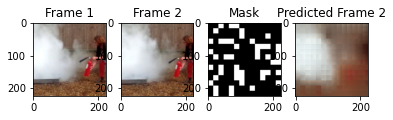

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


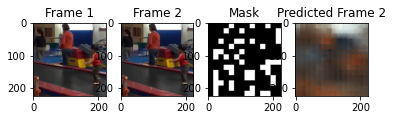

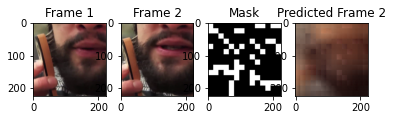

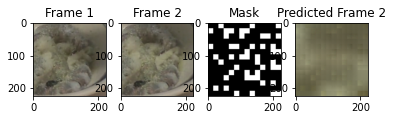

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


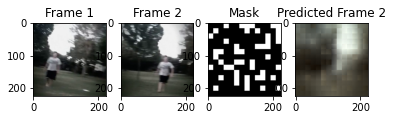

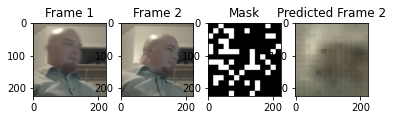

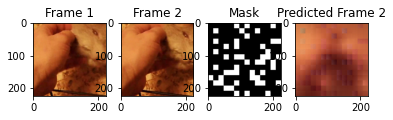

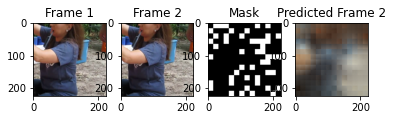

In [24]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    _, my_pred, mask = model(sample.to(device))
    print(my_pred.shape)

    unpatched_pred = model.mae2.unpatchify(my_pred)
    print(unpatched_pred.shape)

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.mae2.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.mae2.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    # torch.Size([8, 4, 3, 224, 224])
    # [BATCH_SIZE x Frames x Channel x Height x Width ]

    for i in range(unpatched_pred.shape[0]):
        fig, axs = plt.subplots(1, 4)
        axs[0].imshow(unnormalize_for_plot(sample[i][0]))
        axs[1].imshow(unnormalize_for_plot(sample[i][1]))
        axs[2].imshow(1-mask[i])
        axs[3].imshow(unnormalize_for_plot(unpatched_pred[i]))  
        axs[0].set_title("Frame 1")
        axs[1].set_title("Frame 2")
        axs[2].set_title("Mask")
        axs[3].set_title("Predicted Frame 2")  
        plt.show()